## A simple one hidden layer neural net example

Start the program

In [1]:
#import py_compile
#py_compile.compile('rbm_classic.py')


print "Starting program"

Starting program


### Start of mnist data setup

Import the needed modules and load the data.

In [3]:
# Import needed modules
import numpy
import theano
import theano.tensor as T
rng = numpy.random
import os
import gzip
import cPickle

try:
    import PIL.Image as Image
except ImportError:
    import Image
from utils import tile_raster_images

print "Looking for mnist data"

#############
# LOAD DATA #
#############
dataset = 'mnist.pkl.gz' 

# Download the MNIST dataset if it is not present
data_dir, data_file = os.path.split(dataset) 

# If the file does not exist and there was no data_dir specified
if not os.path.isfile(dataset) and data_dir == "":
    print "File %s not found" %dataset
    print "Looking in data directory"
    # Check if dataset is in the data directory.
    new_path = os.path.join(
        os.getcwd(),
        "Python",
        "data",
        "mnist",
        dataset
    )
    dataset = new_path

# If the dataset had a data_dir or we added the standard
# data directory, look for the file there
if not os.path.isfile(dataset):
    print "File %s not found" %dataset
    print "Downloading mnist file from web"
    # If the file is still not found, 
    # we download a copy
    import urllib
    origin = (
        'http://www.iro.umontreal.ca/~lisa/deep/data/mnist/mnist.pkl.gz'
    )
    print 'Downloading data from %s' % origin
    urllib.urlretrieve(origin, dataset)
else:
    # If we find the file, we notify the user
    print "File %s found" %dataset

print '... loading data'
# Load the dataset
f = gzip.open(dataset, 'rb')
train_set, valid_set, test_set = cPickle.load(f)
f.close()
print '... data loaded'

#train_set, valid_set, test_set format: tuple(input, target)
#input is an numpy.ndarray of 2 dimensions (a matrix)
#witch row's correspond to an example. target is a
#numpy.ndarray of 1 dimensions (vector)) that have the same length as
#the number of rows in the input. It should give the target
#target to the example with the same index in the input.


start_training   = 0
start_validation = 0
start_testing    = 0

train_set_x, train_set_y = train_set

valid_set_x, valid_set_y = valid_set

test_set_x,  test_set_y  = test_set

Looking for mnist data
File mnist.pkl.gz not found
Looking in data directory
File /Users/vzocca/gitProjects/github/MyTheano/Simple python notebook examples/Python/data/mnist/mnist.pkl.gz found
... loading data
... data loaded


### End of mnist or other data setup

Assign names to the different sets of data

In [4]:
Train = (train_set_x)

Valid = (valid_set_x)
Test =  (test_set_x)

Define training rate and number of training steps.
The training rate defines how fast we move towards
minimising the error (too large a training rate can make
the algorithm overshoot the minimum and never achieve stability).
The number of training steps define after how many steps we 
stop training our network.

In [5]:
#training rate
#tr_rate = 0.01
# number of epochs
#epochs = 10
# number of neurons in hidden layer

neuron = 10
nhidden = neuron*neuron

Declare the symbolic variables.
x will represent the input, i.e. a matrix of random numbers of size feats for each example (this is the D[0] entry defined above.
y will represent the output, i.e. whether the example belongs to class 0 or class 1

In [6]:
feats = Train.shape[1]

# Declare Theano symbolic variables
x = T.matrix("x")

Define the vector of weights and the bias.
There are num_classes weights associated to each feature, where the output is num_classes neurons.
There are num_classes biases since there are num_classes output neurons.
The weights are randomly initialised, the biases can be initialised to 0.0 or a small value.

In [7]:
# Weights of the network
w = theano.shared(rng.normal(0, 1, (feats, nhidden)), borrow = True)

# Biases for input to hidden layer
bh = theano.shared(numpy.full(nhidden, 0.01), borrow = True)

# The biases from hidden to output layer (same as input)
by = theano.shared(numpy.full(feats, 0.01), borrow = True)

Constructing the actual solution. 
Sigma represent the sigmoid 
<br>
$$ \frac{1}{1+exp(-\bf{x}\dot\bf{w}-\bf{b}) } $$ 
<br>

that is expressed in theano as T.nnet.sigmoid().

To check the result, it is enough to check whether sigma is greater than 0.5, otherwise we take the class with the highest output (probability). 
The prediction then can either be 0 or 1 (correct or false) depending on whether the sigmoid is greater or less than 0.5.
The cost function is defined by 

<br>
$$ 
error({\bf w}) = -\frac{1}{N} \sum_{i=1}^{N} [ y^i \ln (\sigma({\bf{x^i}})) + (1-y^i) \ln (1 - \sigma({\bf{x^i}})] 
$$
<br>

where the superscript represents the $i^{th}$ example.

The cost adds a value to reduce the possibility of overfitting by keeping larger weights in check.
Finally, theano will calculate the gradient of the cost function that is used for approximating the solution using linear descent.

In [8]:
training_examples = 100
tr_rate = 1.0/training_examples

x_states = x > numpy.random.rand(training_examples, feats)

hid =  T.nnet.sigmoid(T.dot(x, w) + bh)    # Activation function of hidden layer
hid_states = hid > numpy.random.rand(training_examples, nhidden)

# Construct Theano expression graph
vis = T.nnet.sigmoid(T.dot(hid_states, w.T) + by) 
vis_states = vis > numpy.random.rand(training_examples, feats)

hid2 = T.nnet.sigmoid(T.dot(vis, w) + bh)
hid2_states = hid2 > numpy.random.rand(training_examples, nhidden)

hid_par = T.nnet.sigmoid(T.dot(x, w) + bh)
vis_par = T.nnet.sigmoid(T.dot(hid_par, w.T) + by)
hid2_par = hid2 = T.nnet.sigmoid(T.dot(vis_par, w) + bh)

prediction = vis

# Cross-entropy loss function
#xent = -x * T.log(vis) - (1-x) * T.log(1-vis)
xent = T.sum((x - vis)**2)
parameters = [w, bh, by]  # this line defines all parameters for each layer

cost = xent.mean()

#diag = numpy.asmatrix(-T.dot(T.dot(x, w), hid.T))
energy = -(-T.dot(T.dot(x, w), hid.T) - T.dot(x,by) - T.dot(hid,bh)).mean()
#cost = xent.mean()

pos_associations = T.dot(x.T, hid)
neg_associations = T.dot(vis_par.T, hid2)

# Compute the gradient of the cost  
gparameters = [T.grad(cost, param) for param in parameters]    

wparameters  = [w]
byparameters = [by]
bhparameters = [bh]


update = []
for wparam, byparam, bhparam in zip(wparameters, byparameters, bhparameters):
    update.append((wparam, wparam + tr_rate*(pos_associations - neg_associations)))
    update.append((byparam, byparam + tr_rate*(x.T.sum(axis=1) - vis.T.sum(axis=1))))      
    update.append((bhparam, bhparam + tr_rate*(hid.T.sum(axis=1) - hid2.T.sum(axis=1))))
    
#update = [(param, param - tr_rate * gparam) for param, gparam in zip(parameters, gparameters)]

We create the theano function.
The input is given by the set of features per each example.
The output is given by the class per each example.
The training is performed by updating weights and biases using the gradient calculated times a training rate (in order to avoid overshooting the minimum value).

In [9]:
def free_energy(v_sample):
    ''' Function to compute the free energy '''
    wx_b = T.dot(v_sample, w) + bh
    vbias_term = T.dot(v_sample, by)
    hidden_term = T.sum(T.log(1 + T.exp(wx_b)), axis=1)
    return -hidden_term - vbias_term

#energy = free_energy(x).sum()

# Compile
train = theano.function(
          inputs=[x],
          outputs=[cost],
          updates=update)

predict = theano.function(inputs=[x], outputs=[prediction])

hiddenImg = theano.function(
              inputs=[x],
              outputs=[hid] )

energyVal = theano.function(
            inputs=[x],
            outputs=[energy] )

debug = theano.function(
            inputs=[x],
            outputs = [pos_associations, neg_associations, pos_associations-neg_associations])

Perform the actual training on the data. 
This updates at each step the weighs and bias making the neural net perform better and get closer to the target solution.

In [10]:
def SGD(set):
    # If we don't want to load all the data,
    # we can just load a subset with a small
    # number of examples.
    # Set it to zero or a negative number
    # if you want to load the whole data set
    #training_examples = 100

    # You want to always
    # load the same examples or randomise
    # the subset
    
    start_training   = numpy.random.randint(set.shape[0] - training_examples)

    Train = set[start_training:training_examples + start_training]
    
    return Train

In [11]:
import time

step = 1000
epochs = 10*step

# Train
start_cpu_time = time.clock()
start_time = time.time()

for epoch in xrange(epochs):
    Train = SGD(train_set[0])
    if epoch % step == 0:
        print "Epoch:", epoch
        tmp = time.clock()
        tmp2 = time.time()
    
    #Do 100 epochs on the small subset
    for count in range(1):
        otp = train(Train)
        
    if epoch % step == 0:   
        #print "energy = ", numpy.asarray(energyVal(Train))
        print "cpu time = ", time.clock() - tmp
        print "wall clock time = ", time.time() - tmp2
        print "cost = ", numpy.asarray(otp)
    
    if epoch % step == 0:
        # Construct image from the weight matrix
        image = Image.fromarray(
            tile_raster_images(
            w.get_value(borrow=True).T,
            img_shape=(28, 28),
            tile_shape=(neuron, neuron),
            tile_spacing=(1, 1)
        )
        )
        image.show()
    #print "debug = ", numpy.asarray(debug(Train))
end_cpu_time = time.clock()
end_time = time.time()
print "Average cpu time per epoch=", (end_cpu_time-start_cpu_time)/epochs
print "Average wall clock time per epoch=", (end_time-start_time)/epochs
print "Total cpu time = ", end_cpu_time - start_cpu_time
print "Total time = ", end_time - start_time

Epoch: 0
cpu time =  0.014633
wall clock time =  0.0129919052124
cost =  [ 31341.51683981]
Epoch: 1000
cpu time =  0.011081
wall clock time =  0.00620102882385
cost =  [ 2341.96528312]
Epoch: 2000
cpu time =  0.01134
wall clock time =  0.00692796707153
cost =  [ 2341.46394082]
Epoch: 3000
cpu time =  0.010892
wall clock time =  0.00626611709595
cost =  [ 2184.22744728]
Epoch: 4000
cpu time =  0.011147
wall clock time =  0.00646114349365
cost =  [ 1856.77671022]
Epoch: 5000
cpu time =  0.010754
wall clock time =  0.00609993934631
cost =  [ 1706.87832902]
Epoch: 6000
cpu time =  0.010959
wall clock time =  0.00658702850342
cost =  [ 1565.90355201]
Epoch: 7000
cpu time =  0.010936
wall clock time =  0.00602984428406
cost =  [ 1741.05141098]
Epoch: 8000
cpu time =  0.013219
wall clock time =  0.00796008110046
cost =  [ 1539.28914217]
Epoch: 9000
cpu time =  0.010935
wall clock time =  0.00610113143921
cost =  [ 1487.1119151]
Average cpu time per epoch= 0.0105905894
Average wall clock time 

Calculate the errors, i.e. the numbers of examples in the training set that have not been classified correctly and output the accuracy result.

Results for Training set


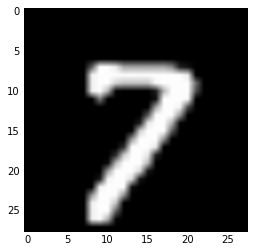

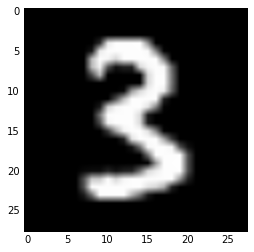

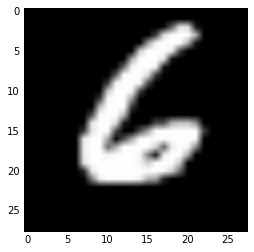

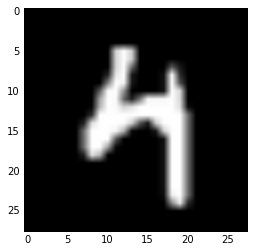

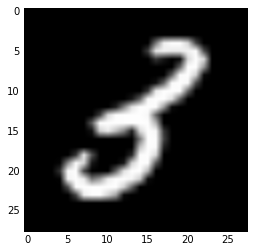

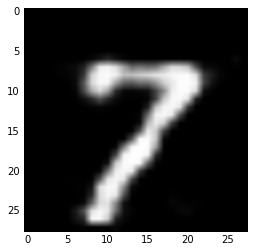

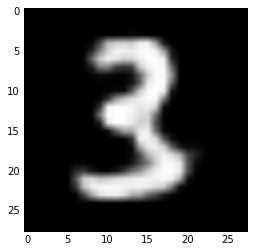

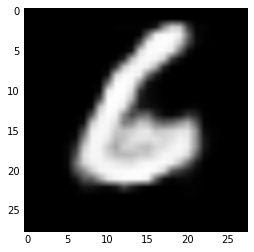

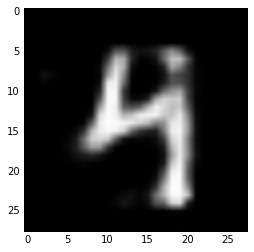

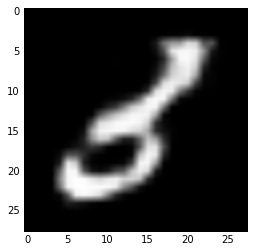

In [12]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm

matplotlib.rcParams['figure.max_open_warning'] = 0

print "Results for Training set"

N = Train.shape[0]
error = 0

if N > 1000 : draw_images = False
result = predict(Train)

N = 5
#for index in range(N):
for index in range(N):  
    if True :
        tmp = numpy.reshape(Train[index], [28, 28])
        plt.figure()
        plt.imshow(tmp, cmap = cm.Greys_r)

# hiddenImg are the values of the neurons in the hidden layer
tmp2 = numpy.asarray(hiddenImg(Train))

t = T.dvector('t')
threshold = 0.001  # change accordingly
t_clipped = t * (t > threshold)

f = theano.function(inputs=[t], outputs=t_clipped)

#for img in range(tmp.shape[1]) :  
for img in range(0) :  
    plt.figure()
    plt.imshow(numpy.reshape(tmp2[0][img], [20, 20]), cmap = cm.Greys_r)
    
# predict values are the values of the neurons in the reconstructed layer
tmp3 = numpy.asarray(predict(Train))

#for img in range(tmp.shape[1]) :  
for img in range(N) :  
    plt.figure()
    plt.imshow(numpy.reshape(tmp3[0][img], [28, 28]), cmap = cm.Greys_r)


In [13]:
try:
    import PIL.Image as Image
except ImportError:
    import Image
from utils import tile_raster_images

print w.T.shape.eval()
print predict(Train)[0].shape
print Train.shape

def show_weights():
    # Construct image from the weight matrix
    image = Image.fromarray(
        tile_raster_images(
            w.get_value(borrow=True).T,
            img_shape=(28, 28),
            tile_shape=(neuron, neuron),
            tile_spacing=(1, 1)
        )
    )
    image.show()

def show_reconstruction(): 
    image = Image.fromarray(
        tile_raster_images(
            predict(Train)[0],
            img_shape=(28, 28),
            tile_shape=(10, 10),
            tile_spacing=(1, 1)
        )
    )
    image.show()

def show_orig():
    image = Image.fromarray(
        tile_raster_images(
            Train,
            img_shape=(28, 28),
            tile_shape=(10, 10),
            tile_spacing=(1, 1)
        )
    )
    image.show()

image.save('filters_at_epoch_.png')
Image.open('filters_at_epoch_.png')

show_orig()
show_reconstruction()
show_weights()

[100 784]
(100, 784)
(100, 784)


In [14]:
v = theano.shared(rng.normal(0, 1, 2))

print
print

z = theano.shared(rng.normal(0, 1, (2, 2)))
print v.eval()
print z.eval()

print
print

print z[:][0].eval()
print T.sum(z.T).eval()
print T.sum(z.T[:][0]).eval()

print numpy.sum([])
print numpy.sum(z[:][0].eval())
print v[0].eval()

y = v[0] + T.sum(z[:][0])

y = v + z.sum(axis=1)

print y.eval()




[ 0.95134741  0.41396539]
[[-0.85705224 -1.12571033]
 [-0.89609898 -0.02190293]]


[-0.85705224 -1.12571033]
-2.90076448234
-1.7531512151
0.0
-1.98276256988
0.951347407513
[-1.03141516 -0.50403652]


In [15]:
Train = SGD(valid_set[0])

print test_set[0].shape[0]
print Train.shape
print predict(Train)[0].shape


show_orig()
show_reconstruction()
show_weights()


10000
(100, 784)
(100, 784)
